In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

#data = pd.read_csv('bitcoin.csv')
data = pd.read_csv('https://raw.githubusercontent.com/ikwak2/hj19_timeseries/main/btc/bitcoin2000.csv?token=GHSAT0AAAAAABQVZROZQE6XK65ACCENOYPEYPPQEBA')

In [3]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad

def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [4]:
def get_integrated_gradients(img_input, top_pred_idx, baseline=None, num_steps=50):
    seq_input = X_test[1]

    if baseline is None:
        baseline = np.zeros(seq_input.shape).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    seq_input = seq_input.astype(np.float32)
    interpolated_seq = [
        baseline + (step / num_steps) * (seq_input - baseline)
        for step in range(num_steps + 1)
    ]

    # 3. Get the gradients
    grads = []
    for i, seq in enumerate(interpolated_seq):
        seq = tf.expand_dims(seq, axis=0)
        with tf.GradientTape() as tape:
            tape.watch(seq)
            preds = model(seq)
        grad = tape.gradient(preds, seq)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (seq_input - baseline) * avg_grads
    return integrated_grads

In [5]:
def get_integrated_gradients_r(img_input, top_pred_idx, baseline1=None, num_steps=50):
    seq_input = X_test[1]

    baseline1 = tf.random.uniform(seq_input.shape, minval=0.0, maxval=1.0)
    # 1. Do interpolation.
    seq_input = seq_input.astype(np.float32)
    interpolated_seq = [
        baseline1 + (step / num_steps) * (seq_input - baseline1)
        for step in range(num_steps + 1)
    ]

    # 3. Get the gradients
    grads = []
    for i, seq in enumerate(interpolated_seq):
        seq = tf.expand_dims(seq, axis=0)
        with tf.GradientTape() as tape:
            tape.watch(seq)
            preds = model(seq)
        grad = tape.gradient(preds, seq)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (seq_input - baseline1) * avg_grads
    return integrated_grads

In [29]:
def get_integrated_gradients_m(img_input, top_pred_idx, baseline2=None, num_steps=50):
    seq_input = X_test[1]
    
    mean = np.nanmean(seq_input)
    baseline2 = np.full(seq_input.shape, mean)
    # 1. Do interpolation.
    seq_input = seq_input.astype(np.float32)
    interpolated_seq = [
        baseline2 + (step / num_steps) * (seq_input - baseline2)
        for step in range(num_steps + 1)
    ]

    # 3. Get the gradients
    grads = []
    for i, seq in enumerate(interpolated_seq):
        seq = tf.expand_dims(seq, axis=0)
        with tf.GradientTape() as tape:
            tape.watch(seq)
            preds = model(seq)
        grad = tape.gradient(preds, seq)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (seq_input - baseline2) * avg_grads
    return integrated_grads

In [6]:
data

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,timeUTC
0,1576144800,7219.93,7149.15,7170.18,1536.79,11041994.81,7166.14,direct,NaN,2019-12-12 19:00:00
1,1576148400,7208.36,7166.03,7166.14,785.11,5654607.43,7199.79,direct,NaN,2019-12-12 20:00:00
2,1576152000,7222.43,7194.87,7199.79,672.46,4855213.22,7199.97,direct,NaN,2019-12-12 21:00:00
3,1576155600,7211.80,7187.29,7199.97,807.61,5821087.81,7201.38,direct,NaN,2019-12-12 22:00:00
4,1576159200,7229.22,7152.84,7201.38,1606.06,11537799.57,7173.50,direct,NaN,2019-12-12 23:00:00
...,...,...,...,...,...,...,...,...,...,...
10000,1612144800,33847.46,33257.39,33450.01,2066.49,69445570.35,33675.45,direct,NaN,2021-02-01 11:00:00
10001,1612148400,33779.76,33505.50,33675.45,1173.82,39473368.04,33590.20,direct,NaN,2021-02-01 12:00:00
10002,1612152000,33945.41,33404.87,33590.20,1430.06,48159838.72,33576.82,direct,NaN,2021-02-01 13:00:00
10003,1612155600,33907.89,33467.87,33576.82,1198.20,40319458.23,33803.02,direct,NaN,2021-02-01 14:00:00


In [7]:
'''
from sklearn.preprocessing import MinMaxScaler
values = data[['close','high','low','open','volumefrom','volumeto']].values.reshape(-1,6)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values) '''

"\nfrom sklearn.preprocessing import MinMaxScaler\nvalues = data[['close','high','low','open','volumefrom','volumeto']].values.reshape(-1,6)\nvalues = values.astype('float32')\nscaler = MinMaxScaler(feature_range=(0, 1))\nscaled = scaler.fit_transform(values) "

In [8]:
from sklearn.preprocessing import MinMaxScaler
values = data[['close','high','low','open','volumefrom','volumeto']].values.reshape(-1,6)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled=scaler.fit_transform(values)
#scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))
#scaled = (values - np.mean(values))/np.std(values) 

In [9]:
np.max(values)

7859574300.0

In [10]:
np.min(values)

161.86

In [11]:
np.max(values)-np.min(values)

7859574300.0

In [12]:
scaled

array([[7.8535259e-02, 6.9533341e-02, 8.6421244e-02, 7.8643724e-02,
        5.8386968e-03, 1.2568906e-03],
       [7.9438612e-02, 6.9223486e-02, 8.6877085e-02, 7.8535259e-02,
        2.6466567e-03, 5.7133357e-04],
       [7.9443455e-02, 6.9600292e-02, 8.7655909e-02, 7.9438612e-02,
        2.1682840e-03, 4.6960887e-04],
       ...,
       [7.8754401e-01, 7.8523761e-01, 7.9544908e-01, 7.8790319e-01,
        5.3854641e-03, 5.9802183e-03],
       [7.9361647e-01, 7.8423285e-01, 7.9715037e-01, 7.8754401e-01,
        4.4008605e-03, 4.9825124e-03],
       [7.9614097e-01, 7.8537852e-01, 8.0448914e-01, 7.9361647e-01,
        1.7305929e-03, 2.3062201e-03]], dtype=float32)

In [13]:

train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:]
print(len(train),len(val), len(test))

8004 1000 1001


In [14]:
def create_dataset_multistep(dataset, look_back=1,predict=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-predict):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i+ look_back-1: i+ look_back+predict-1, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [15]:
look_back = 168
predict=24
trainX, trainY = create_dataset_multistep(train, look_back,predict)
valX, valY = create_dataset_multistep(val, look_back,predict)
testX, testY = create_dataset_multistep(test, look_back,predict)

7812
808
809


In [16]:
testX

array([[[0.5081322 , 0.4972723 , 0.50418204, 0.49842197, 0.01987398,
         0.01396313],
        [0.50627834, 0.49758053, 0.51247734, 0.5081322 , 0.01269652,
         0.00910186],
        [0.5095518 , 0.50080806, 0.5140396 , 0.50627834, 0.01281198,
         0.00923004],
        ...,
        [0.60594934, 0.5949154 , 0.61132294, 0.602308  , 0.00614555,
         0.00532355],
        [0.6126975 , 0.6016524 , 0.61389863, 0.60594934, 0.00730702,
         0.00630235],
        [0.61675006, 0.611603  , 0.6242047 , 0.6126975 , 0.01305175,
         0.01107979]],

       [[0.50627834, 0.49758053, 0.51247734, 0.5081322 , 0.01269652,
         0.00910186],
        [0.5095518 , 0.50080806, 0.5140396 , 0.50627834, 0.01281198,
         0.00923004],
        [0.4960037 , 0.49831617, 0.5053867 , 0.5095518 , 0.01790486,
         0.01260215],
        ...,
        [0.6126975 , 0.6016524 , 0.61389863, 0.60594934, 0.00730702,
         0.00630235],
        [0.61675006, 0.611603  , 0.6242047 , 0.6126975 , 0.013

In [17]:

print(trainX.shape)
print(trainY.shape)

(7812, 168, 6)
(7812, 24)


In [18]:
SMALL_SIZE = 20
MEDIUM_SIZE = 23
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE) # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE) # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) # fontsize of the figure title

CNN-LSTM

In [30]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,6))

in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2, name='extractor')(in1)
#in1=Dropout(0.5)(in1)
#in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
in1=LSTM(100)(in1)
in1=Dense(100)(in1)
in1=Dropout(0.5)(in1)
out=Dense(24)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_cnnlstm_multistep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [31]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/btc_cnnlstm_multistep.hdf5")

In [32]:
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 168, 6)]          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 168, 64)           1216      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 168, 64)           8256      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 168, 64)           4160      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 168, 64)           12352     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 168, 64)           8256      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 168, 64)          

1.0
0.0
1.0
(168, 6)


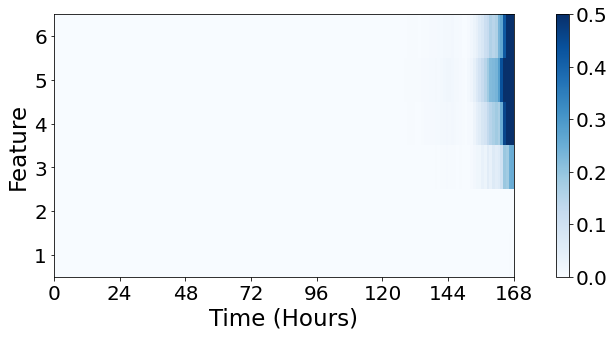

In [22]:
id_=24*12
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = get_integrated_gradients(X_test[id_], model, baseline = X_test[id_-1])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Feature')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

#plt.savefig('png/btc_feature int_grad_cnn-lstm(1).png')

1.0
0.0
1.0
(168, 6)


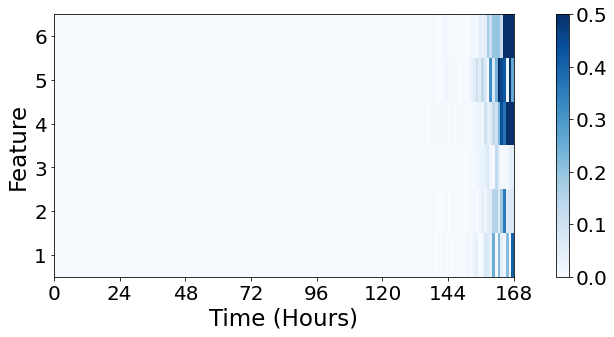

In [22]:
id_=24*12
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = get_integrated_gradients_r(X_test[id_], model, baseline1 = X_test[id_-1])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Feature')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()
plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/png/btc_i_g_random_cnn-lstm.png')

1.0
0.0
1.0
(168, 6)


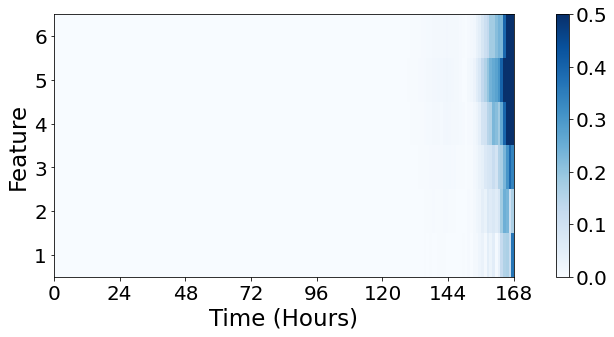

In [33]:
id_=24*12
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = get_integrated_gradients_m(X_test[id_], model, baseline2 = X_test[id_-1])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Feature')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()
plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/png/btc_i_g_mean_cnn-lstm.png')

LSTM-CNN

In [34]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,6))

in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=Flatten()(in1)
in1=Dense(100, activation='relu')(in1)

in1=Dropout(0.5)(in1)
out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_lstmcnn_mulstep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [35]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/btc_lstmcnn_mulstep.hdf5")

1.0
0.0
1.0
(168, 6)


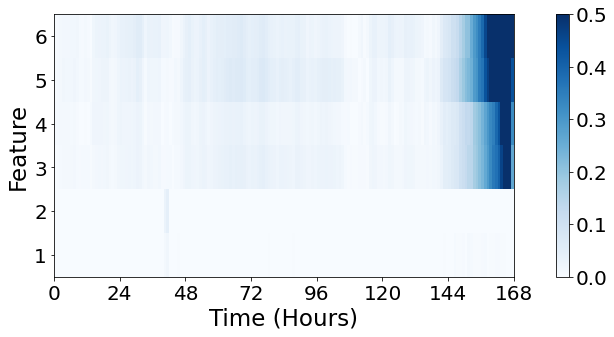

In [25]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = get_integrated_gradients(X_test[id_], model, baseline = X_test[id_-1])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Feature')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

1.0
0.0
1.0
(168, 6)


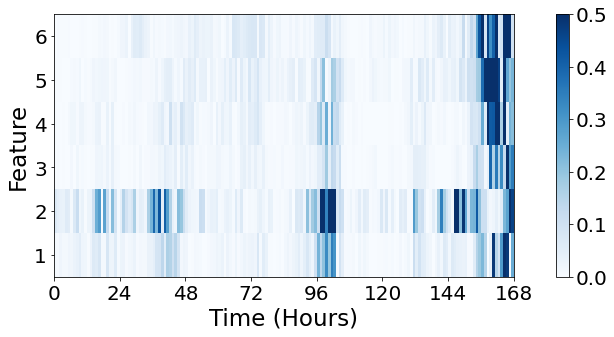

In [25]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = get_integrated_gradients_r(X_test[id_], model, baseline1 = X_test[id_-1])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Feature')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()
plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/png/btc_i_g_random_lstm-cnn.png')

1.0
0.0
1.0
(168, 6)


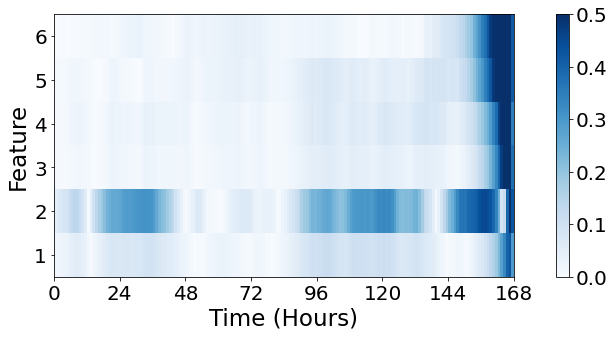

In [36]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = get_integrated_gradients_m(X_test[id_], model, baseline2 = X_test[id_-1])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Feature')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()
plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/png/btc_i_g_mean_lstm-cnn.png')

LSTM-resCNN




In [37]:
from tensorflow.keras.models import Model

first_input = Input(shape=(168,6))

in0=LSTM(64,return_sequences=True)(first_input)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor1')

#ad=Dropout(0.5)(ad)
#in0=LSTM(64,return_sequences=True)(ad)
#in1=add([first_input,in0])
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in1= BatchNormalization(scale=False)(in1)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

in1=add([in0,in1],name='extractor')


in1=Flatten()(in1)
in1=Dense(100, activation='relu')(in1)
in1=Dropout(0.5)(in1)

out=Dense(24,'relu')(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_lstmrescnn_mulstep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [38]:
model.load_weights("C:/Users/mozzimerci/jupyter notebook/time/chan/ff/saved_weights/btc_lstmrescnn_mulstep.hdf5")

1.0
0.0
1.0
(168, 6)


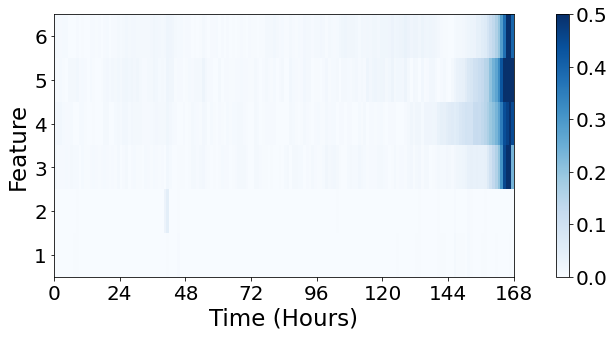

In [28]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = get_integrated_gradients(X_test[id_], model, baseline = X_test[id_-1])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Feature')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()

1.0
0.0
1.0
(168, 6)


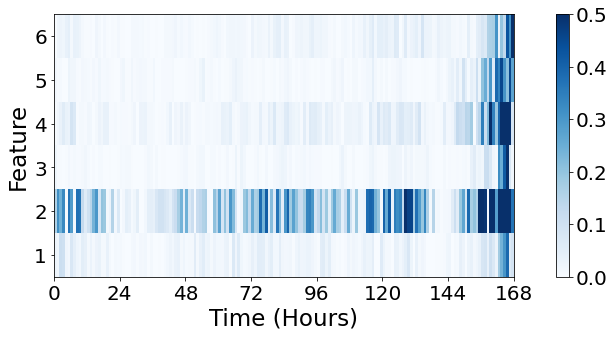

In [28]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = get_integrated_gradients_r(X_test[id_], model, baseline1 = X_test[id_-1])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Feature')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()
plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/png/btc_i_g_random_lstm-rescnn.png')

1.0
0.0
1.0
(168, 6)


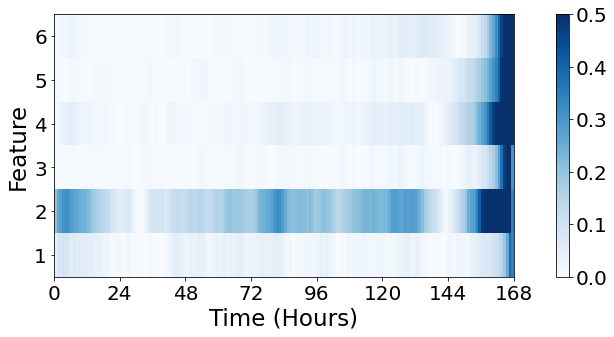

In [39]:
import matplotlib.pyplot as plt
import numpy as np

X_test=testX
grad_weight = get_integrated_gradients_m(X_test[id_], model, baseline2 = X_test[id_-1])

grad_weight_abs = abs(grad_weight)

grad_weight_abs_z = (grad_weight_abs-(np.min(grad_weight_abs)))/(np.max(grad_weight_abs)-(np.min(grad_weight_abs)))

print(np.max(grad_weight_abs_z))
print(np.min(grad_weight_abs_z))
print(np.max(grad_weight_abs_z)-np.min(grad_weight_abs_z))
#grad_weight=grad_weight.reshape(48,4)

print(grad_weight_abs_z.shape)

#plt.plot(X_test[8], 'k')
a=grad_weight_abs_z.numpy()
a=a.reshape(168,6)
a=a.transpose()
#print(a)
fig, ax = plt.subplots(1,1, figsize=(15,5))

y_label_list = [1,2,3,4,5,6]
x_label_list = [0,24,48,72,96,120,144,168]
ax.set_xticks([0,24,48,72,96,120,144,168])

ax.set_yticks([8,24,40,56,72,88])

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)

ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
ax.set_xlabel('Time (Hours)')
ax.set_ylabel('Feature')
plt.subplots_adjust(bottom=0.15)

plt.imshow(a,extent = [0 , 168, 0 , 96], vmin=0, vmax=0.5, cmap="Blues", interpolation='nearest')
plt.colorbar()
plt.savefig('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/png/btc_i_g_mean_lstm-rescnn.png')

### i_g 데이터 확인

In [40]:
id_

288

In [41]:
print(len(train),len(val), len(test))

8004 1000 1001


In [46]:
8004+1000+288

9292

In [47]:
9292+168

9460

In [44]:
X_test[id_]

array([[0.7273472 , 0.72131866, 0.7340606 , 0.73193514, 0.02638346,
        0.0252174 ],
       [0.73899794, 0.72950095, 0.7367835 , 0.7273472 , 0.0232578 ,
        0.02248864],
       [0.75915784, 0.76203257, 0.7511514 , 0.73899794, 0.05742903,
        0.05641037],
       ...,
       [0.9761269 , 0.98008347, 0.9817159 , 0.9710165 , 0.0123252 ,
        0.01578645],
       [0.98356545, 0.97305703, 0.9863801 , 0.9761269 , 0.00582222,
        0.00779525],
       [0.98964167, 0.9812995 , 0.9946214 , 0.98356545, 0.00838378,
        0.01100693]], dtype=float32)

In [48]:
scaled[9292:9460]

array([[0.7273472 , 0.72131866, 0.7340606 , 0.73193514, 0.02638346,
        0.0252174 ],
       [0.73899794, 0.72950095, 0.7367835 , 0.7273472 , 0.0232578 ,
        0.02248864],
       [0.75915784, 0.76203257, 0.7511514 , 0.73899794, 0.05742903,
        0.05641037],
       ...,
       [0.9761269 , 0.98008347, 0.9817159 , 0.9710165 , 0.0123252 ,
        0.01578645],
       [0.98356545, 0.97305703, 0.9863801 , 0.9761269 , 0.00582222,
        0.00779525],
       [0.98964167, 0.9812995 , 0.9946214 , 0.98356545, 0.00838378,
        0.01100693]], dtype=float32)

In [58]:
data_1=data[['time','close','high','low','open','volumefrom','volumeto']]
data_2 = data_1[8472:8640]
data_2

,time,close,high,low,open,volumefrom,volumeto
8472,1606644000,18203.58,18226.46,18060.48,18111.74,962.36,17463384.73
8473,1606647600,18100.77,18243.95,18025.07,18203.58,1430.56,25929271.57
8474,1606651200,18042.94,18144.61,17931.10,18100.77,1437.50,25916297.84
8475,1606654800,18104.34,18132.76,18026.06,18042.94,1081.19,19547368.16
8476,1606658400,18058.32,18205.78,18051.62,18104.34,1287.61,23349759.79
...,...,...,...,...,...,...,...
8635,1607230800,19168.76,19209.76,19116.92,19191.83,460.21,8807536.73
8636,1607234400,19188.33,19220.05,19146.71,19168.76,372.96,7147985.96
8637,1607238000,19229.56,19240.90,19182.95,19188.33,323.86,6214631.51
8638,1607241600,19022.07,19244.76,19012.65,19229.56,995.36,19022552.63


In [59]:
data_2.to_excel('C:/Users/mozzimerci/jupyter notebook/time/chan/i_g/data/btc_i_g_data.xlsx', index=False)

<Figure size 720x720 with 0 Axes>

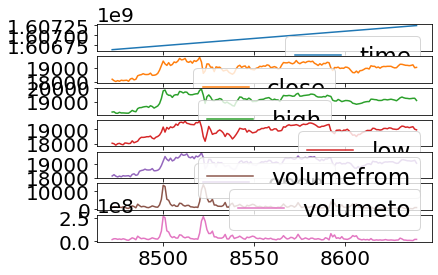

In [60]:
plt.figure(figsize = (10, 10))
data_2.plot(subplots=True)
plt.show()